In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow import keras
from glob import glob
import matplotlib.pyplot as plt

In [2]:
Image_size=256
Batch_size=64
Channels=3
epochs=35

In [3]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.10.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
dataset=keras.preprocessing.image_dataset_from_directory(
    "C:/Users/cn807/OneDrive/Desktop/ML And DL/ML_AND_DL/My_Projects/Food_recognition_and_Nutrition_Analysis/Food_Data",
    shuffle=True,
    color_mode='rgb',
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 6269 files belonging to 20 classes.


In [5]:
classnames=dataset.class_names

In [6]:
classnames

['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']

In [7]:
len(classnames)

20

In [8]:
len(dataset)

98

In [9]:
98*Batch_size#every element is a batch of 32

6272

In [10]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[246.       250.       251.      ]
  [246.       250.       251.      ]
  [246.       250.       251.      ]
  ...
  [241.       249.       252.      ]
  [241.       249.       252.      ]
  [241.       249.       252.      ]]

 [[246.       250.       251.      ]
  [246.       250.       251.      ]
  [246.       250.       251.      ]
  ...
  [241.       249.       252.      ]
  [241.       249.       252.      ]
  [241.       249.       252.      ]]

 [[246.       250.       251.      ]
  [246.       250.       251.      ]
  [246.       250.       251.      ]
  ...
  [241.       249.       252.      ]
  [241.       249.       252.      ]
  [241.       249.       252.      ]]

 ...

 [[234.54688  226.85474  208.83911 ]
  [230.64062  227.35938  215.35938 ]
  [228.       228.       218.      ]
  ...
  [ 79.46875   44.46875    3.      ]
  [ 86.388916  50.204834   0.      ]
  [ 88.62964   52.921875   0.      ]]

 [[230.16284  224.16284  209.06909 ]
  [231.4104   226.12915  2

In [11]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape, label_batch)

(256, 256, 3) tf.Tensor(
[13  8 17  7  1  6  3 17  0 12  3  0 14 19 17  3 11 10 11  0 14 19  0 15
 19 14  6  3  4 14 16  9  7  3 10  1  4  2  2  7  0 14  2 18  5  1  5 19
  1  2  8 11  6  7  9  4  6 12 16 15 10  9 11 11], shape=(64,), dtype=int32)


In [15]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape, len(label_batch))

(64, 256, 256, 3) 64


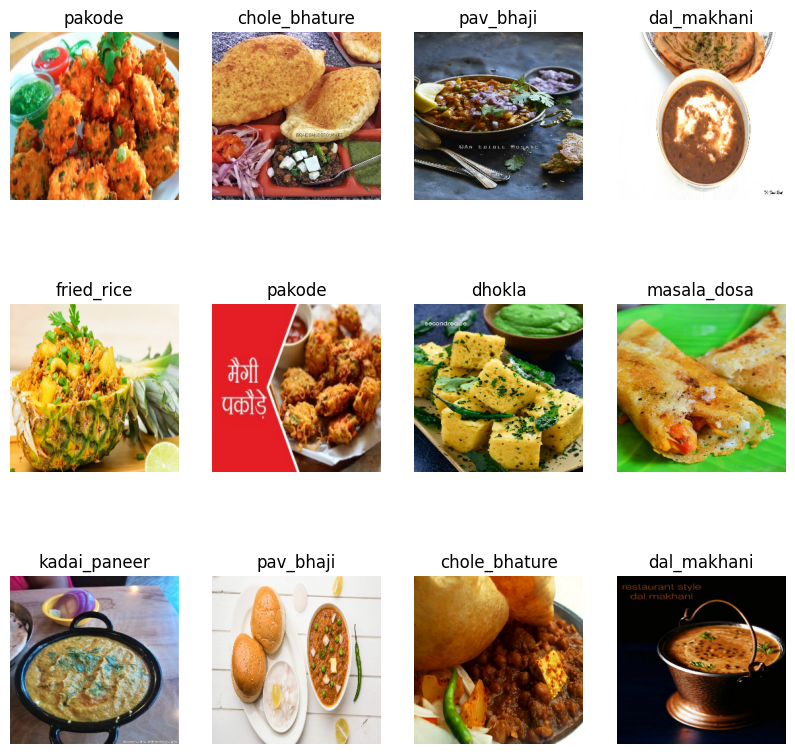

In [16]:
plt.figure(figsize=(10,10))
#for 1st take of batch there are 32 images i want to see the 10 images of 1st batch
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))#accepts 3d input
        plt.title(classnames[labels_batch[i]])
        plt.axis("off")

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

78

In [20]:
# resize_and_rescale = tf.keras.Sequential([
#   keras.layers.experimental.preprocessing.Resizing(Image_size, Image_size),
#   keras.layers.experimental.preprocessing.Rescaling(1./255),
# ])

In [21]:
data_augmentation = tf.keras.Sequential([
  keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
# train_ds = train_ds.map(
#     lambda x, y: (resize_and_rescale(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
len(train_ds)

78

In [25]:
vgg16 = VGG16(input_shape=(Image_size,Image_size,3), weights='imagenet', include_top=False)
for layer in vgg16.layers:
    layer.trainable = False
tmp = Flatten()(vgg16.output)
num_classes=20
prediction = Dense(num_classes, activation='softmax')(tmp)

# create a model object
model = Model(inputs=vgg16.input, outputs=prediction)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
        train_ds,
        batch_size=Batch_size,
        validation_data=val_ds,
        verbose=1,
        epochs=20
    )

Epoch 1/20
78/78 [==============================] - 88s 659ms/step - loss: 25.5631 - accuracy: 0.4488 - val_loss: 14.6210 - val_accuracy: 0.6701
Epoch 2/20
78/78 [==============================] - 73s 636ms/step - loss: 16.9020 - accuracy: 0.6444 - val_loss: 11.1140 - val_accuracy: 0.7708
Epoch 3/20
78/78 [==============================] - 74s 626ms/step - loss: 13.7986 - accuracy: 0.7212 - val_loss: 12.1609 - val_accuracy: 0.7899
Epoch 4/20
78/78 [==============================] - 73s 630ms/step - loss: 12.3080 - accuracy: 0.7644 - val_loss: 9.2898 - val_accuracy: 0.8056
Epoch 5/20
78/78 [==============================] - 95s 913ms/step - loss: 12.0216 - accuracy: 0.7763 - val_loss: 7.8092 - val_accuracy: 0.8368
Epoch 6/20
78/78 [==============================] - 78s 688ms/step - loss: 10.2676 - accuracy: 0.8056 - val_loss: 6.9684 - val_accuracy: 0.8785
Epoch 7/20
78/78 [==============================] - 75s 667ms/step - loss: 10.3610 - accuracy: 0.8167 - val_loss: 9.1549 - val_accura

In [29]:
scores = model.evaluate(test_ds)

11/11 [==============================] - 25s 195ms/step - loss: 2.5589 - accuracy: 0.9545


In [30]:
scores

[2.558915853500366, 0.9545454382896423]

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

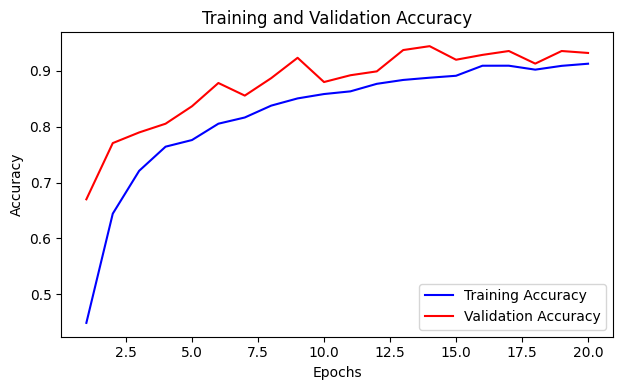

In [39]:
epochs = range(1, 21)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

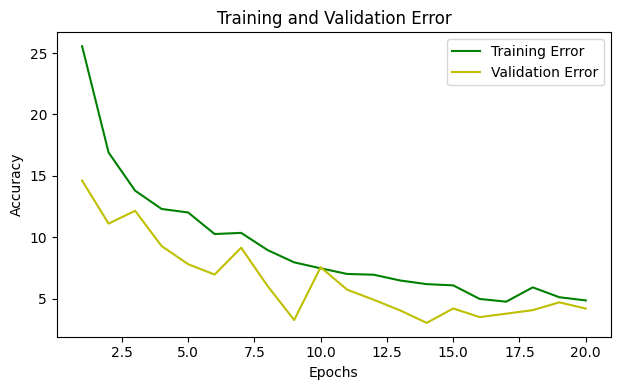

In [42]:
epochs = range(1, 21)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'g', label='Training Error')
plt.plot(epochs, val_loss, 'y', label='Validation Error')
plt.title('Training and Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
x_test = []
y_test = []
for img,label in test_ds:
    x_test.append(img)
    y_test.append(label)

In [67]:
x_test = np.array(x_test)
y_test = np.array(y_test)

In [69]:
x_test.shape , y_test.shape

((11, 64, 256, 256, 3), (11, 64))

In [71]:
x_test = x_test.reshape(64*11,256,256,3)
y_test = y_test.reshape(64*11,)

In [72]:
x_test.shape , y_test.shape

((704, 256, 256, 3), (704,))

In [73]:
y_pred = model.predict(x_test)

22/22 [==============================] - 3s 92ms/step


In [74]:
y_pred.shape

(704, 20)

In [75]:
y_pred = np.array([np.argmax(i) for i in y_pred])

In [76]:
y_pred.shape

(704,)

In [77]:
y_pred[:10]

array([ 6, 15,  5,  1,  6,  0, 18,  6, 14, 10], dtype=int64)

In [78]:
y_test[:10]

array([ 6, 15,  5,  1,  6,  0, 18,  6, 14, 10])

In [79]:
from sklearn.metrics import classification_report,confusion_matrix

In [81]:
mat = confusion_matrix(y_test,y_pred)

In [82]:
import seaborn as sns

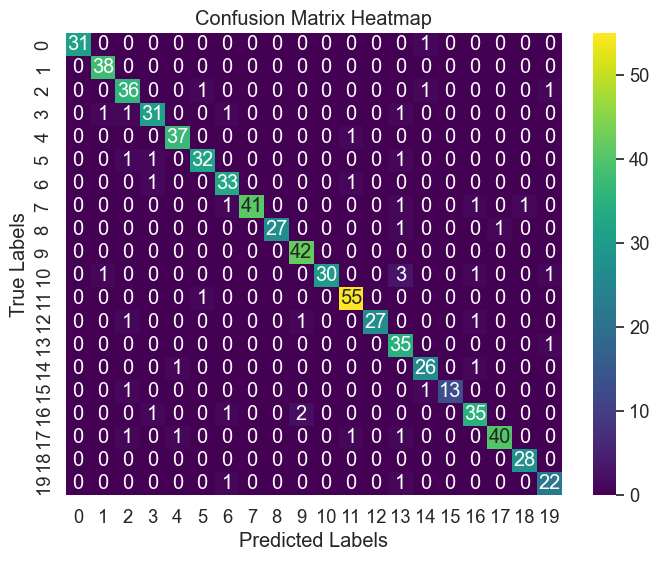

In [90]:
plt.figure(figsize=(8, 6))
sns.heatmap(mat, annot=True,cmap='viridis' , fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [91]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        32
           1       0.95      1.00      0.97        38
           2       0.88      0.92      0.90        39
           3       0.91      0.89      0.90        35
           4       0.95      0.97      0.96        38
           5       0.94      0.91      0.93        35
           6       0.89      0.94      0.92        35
           7       1.00      0.91      0.95        45
           8       1.00      0.93      0.96        29
           9       0.93      1.00      0.97        42
          10       1.00      0.83      0.91        36
          11       0.95      0.98      0.96        56
          12       1.00      0.90      0.95        30
          13       0.80      0.97      0.88        36
          14       0.90      0.93      0.91        28
          15       1.00      0.87      0.93        15
          16       0.90      0.90      0.90        39
          17       0.98    

In [32]:
model.save("my_model.h5")

In [33]:
model.save('../Models/3')

INFO:tensorflow:Assets written to: ../Models/3\assets


INFO:tensorflow:Assets written to: ../Models/3\assets
